##   Name: VIKNESH RAJARAMON                
## ASU ID: 1229281354

# Problem 1 (Cross-Validation)

Following is the code taken from the scikit-learn website (https://scikit-learn.org/stable/auto_examples/applications/plot_tomography_l1_reconstruction.html)

[2pt] The author claims that the alpha value (0.001) is chosen by running the cross validation using LassoCV. Your task is to validate the claim by writing the code for performing LassoCV (from scikit-learn). Construct a set containing at least 5 candiate alpha values (of course, including 0.001) and perform LassoCV. Check whether LassoCV gives 0.001.

In [1]:
%matplotlib inline

# Compressive sensing: tomography reconstruction with L1 prior (Lasso) [2pt]

This example shows the reconstruction of an image from a set of parallel
projections, acquired along different angles. Such a dataset is acquired in
**computed tomography** (CT).

Without any prior information on the sample, the number of projections
required to reconstruct the image is of the order of the linear size
``l`` of the image (in pixels). For simplicity we consider here a sparse
image, where only pixels on the boundary of objects have a non-zero
value. Such data could correspond for example to a cellular material.
Note however that most images are sparse in a different basis, such as
the Haar wavelets. Only ``l/7`` projections are acquired, therefore it is
necessary to use prior information available on the sample (its
sparsity): this is an example of **compressive sensing**.

The tomography projection operation is a linear transformation. In
addition to the data-fidelity term corresponding to a linear regression,
we penalize the L1 norm of the image to account for its sparsity. The
resulting optimization problem is called the `lasso`. We use the
class :class:`~sklearn.linear_model.Lasso`, that uses the coordinate descent
algorithm. Importantly, this implementation is more computationally efficient
on a sparse matrix, than the projection operator used here.

The reconstruction with L1 penalization gives a result with zero error
(all pixels are successfully labeled with 0 or 1), even if noise was
added to the projections. In comparison, an L2 penalization
(:class:`~sklearn.linear_model.Ridge`) produces a large number of labeling
errors for the pixels. Important artifacts are observed on the
reconstructed image, contrary to the L1 penalization. Note in particular
the circular artifact separating the pixels in the corners, that have
contributed to fewer projections than the central disk.

Automatically created module for IPython interactive environment
Alpha values =  [0.001, 0.009, 0.0001, 0.0002658, 0.05, 0.1, 0.001358, 0.13647863, 7.8963e-07, 0.0071301]
Best alpha value from LassoCV =  0.0001


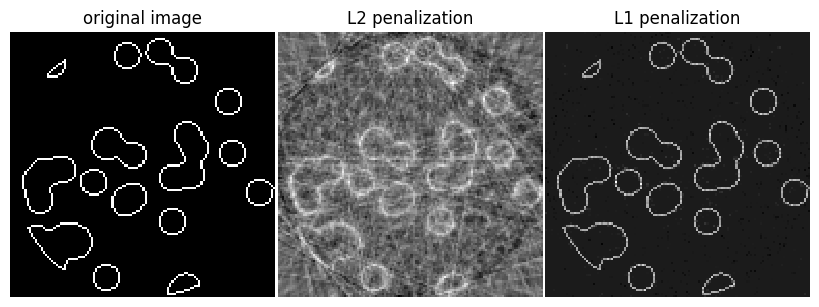

In [2]:
print(__doc__)

# Author: Emmanuelle Gouillart <emmanuelle.gouillart@nsup.org>
# License: BSD 3 clause

import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV


def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))


def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y


def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator


def generate_synthetic_data():
    """ Synthetic binary data """
    rs = np.random.RandomState(0)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))


# Generate synthetic images, and projections
l = 128
proj_operator = build_projection_operator(l, l // 7)
data = generate_synthetic_data()
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape)

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Cross Validation using LassoCV
# Returns the best alpha value
alphas = [0.001, 0.009, 0.0001, 0.0002658, 0.05, 0.1, 0.001358, 0.13647863, 0.00000078963, 0.0071301]
print("Alpha values = ", alphas)
lasso_cv = LassoCV(alphas=alphas, cv=5, n_jobs=-1, max_iter=int(1e6))
lasso_cv.fit(proj_operator, proj.ravel())

best_alpha_from_lassocv = lasso_cv.alpha_
print("Best alpha value from LassoCV = ", best_alpha_from_lassocv)

# Reconstruction with L1 (Lasso) penalization
# the best value of alpha was determined using cross validation
# with LassoCV
rgr_lasso = Lasso(alpha=best_alpha_from_lassocv)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.figure(figsize=(8, 3.3))
plt.subplot(131)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.subplot(132)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2 penalization')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0,
                    right=1)

plt.show()

# Problem 2 (Classification)

In this homework, there are three different datasets consisting of 2-dimensional input features and binary class labels, and you will be asked to implement machine learning classifiers. Total 3 pts.

Let's begin by importing some libaries.

In [1]:
import sys; sys.path.append('../..') ; sys.path.append('..') ; from my_utils import *

import torch 
import torch.nn as nn
import torch.utils.data as data
# dummy trainloader 
trainloader = data.DataLoader(data.TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1, shuffle=True) 
device = torch.device('cpu')

import matplotlib.pyplot as plt

Next, we set a random seed for reproducibility.

In [2]:
import numpy as np
import random

seed = 0
np.random.seed(seed)
torch.random.manual_seed(seed)
random.seed(seed)

# Two Gaussian blobs

This is the first dataset, Gaussian distributed.  

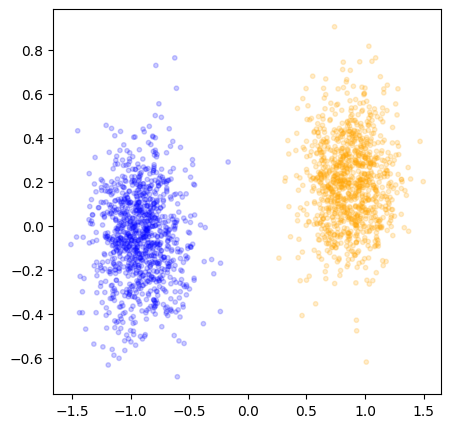

In [3]:
X, y = sample_gaussian()
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_scatter(ax, X, y)

Your task is to build a binary classifier based on logistic regression.

[1 pt] Fill in the following class template to perform logistic regression. 

In [4]:
class Model(nn.Module):
    def __init__(self,device="cpu"):
        super(Model, self).__init__()
        self.linear = nn.Linear(2, 1)

    def forward(self, x):
        y = torch.sigmoid(self.linear(x))
        return y

In [5]:
model = Model().to(device)

We will be using AdamW optimizer.

In [6]:
import torch.optim as optim
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-6)

With the defined model (logistic_reg) and the optimizer, we will train the model using binary cross entropy. 

[1 pt] Finish implementing the training loop.

In [7]:
for itr in range(1, 200001):
    optimizer.zero_grad()
    yh = model(X) # forward pass
    # compute loss
    criterion = nn.BCELoss()
    loss = criterion(yh, y.reshape(len(y), 1).float())
    
    if (itr - 1) % 1000 == 0:
        print(itr, loss.item())
    
    loss.backward() # backward pass
    optimizer.step()
print(itr, loss.item())

1 0.43376824259757996
1001 0.02005038782954216
2001 0.00736762210726738
3001 0.003787943162024021
4001 0.0022306146565824747
5001 0.0014092859346419573
6001 0.0009277305216528475
7001 0.0006263250252231956
8001 0.0004292218654882163
9001 0.0002963828155770898
10001 0.0002050428302027285
11001 0.00014149732305668294
12001 9.707611752673984e-05
13001 6.605769885936752e-05
14001 4.451479617273435e-05
15001 2.968542139569763e-05
16001 1.9588633222156204e-05
17001 1.2796547707694117e-05
18001 8.282734597742092e-06
19001 5.317820978234522e-06
20001 3.391136715436005e-06
21001 2.1504745291167637e-06
22001 1.3577790696217562e-06
23001 8.54674908623565e-07
24001 5.366404707274341e-07
25001 3.368284069438232e-07
26001 2.1157497087642696e-07
27001 1.332005012955051e-07
28001 8.446644983450824e-08
29001 5.391498092421898e-08
30001 3.488116107064343e-08
31001 2.3078728261793913e-08
32001 1.5626996585638153e-08
33001 1.0945947259699551e-08
34001 8.05300981454593e-09
35001 6.03535399434918e-09
36001 

With the trained model, make predictions on training set. 

[1 pt] Draw a plot depicting the data points that are color coded based on the predicted labels, and the decision boundary leared by the logistic regression. See the example below.

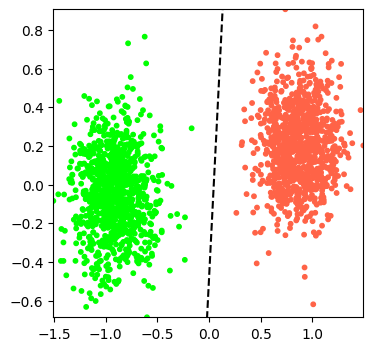

In [8]:
parameters = torch.nn.utils.parameters_to_vector(model.parameters())

with torch.no_grad():
    fig = plt.figure(figsize=(4,4))

    m = -(parameters[0].item() / parameters[1].item())
    c = -(parameters[2].item() / parameters[1].item())

    x_line = np.linspace(X[ : , 0].min(), X[ : , 0].max(), 400)
    y_line = m*x_line + c

    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    plt.xlim(x_min, x_max)

    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    plt.ylim(y_min, y_max)

    colors = ['lime', 'tomato']
    plt.scatter(X[ : , 0], X[ : , 1], c = [colors[int(yi)] for yi in y], s = 10)
    plt.plot(x_line, y_line, c = 'black', linestyle = 'dashed')

    plt.show()

# Problem 3 (Derivative of Loss term)

$$ l(\theta) = y \log (h(\theta^Tx)) + (1-y) \log (1-h(\theta^Tx)) \text{ where } h(z) = \frac{1}{1+e^{-z}} \text{ , } \theta = \begin{bmatrix} \theta _0 \\ \theta _1 \\ \theta _2 \end{bmatrix} \text{ and } x = \begin{bmatrix} 1 \\ x_1 \\ x_2 \end{bmatrix} $$

$$ \text{Let } z = \theta ^Tx = \theta _0 + \theta _1x_1 + \theta _2x2 \text{ --------------------- (Eq. (1))} $$

$$ \frac{\partial z}{\partial \theta _0} = \frac{\partial (\theta _0 + \theta _1x_1 + \theta _2x_2)}{\partial \theta _0} = \frac{\partial (\theta _0)}{\partial \theta _0} + \frac{\partial (\theta _1x_1)}{\partial \theta _0} + \frac{\partial (\theta _2x_2)}{\partial \theta _0} = 1 + 0 + 0 = 1 \text{ --------------------- (Eq. (2))} $$

$$ \frac{\partial z}{\partial \theta _1} = \frac{\partial (\theta _0 + \theta _1x_1 + \theta _2x_2)}{\partial \theta _1} = \frac{\partial (\theta _0)}{\partial \theta _1} + \frac{\partial (\theta _1x_1)}{\partial \theta _1} + \frac{\partial (\theta _2x_2)}{\partial \theta _1} = 0 + x_1 + 0 = x_1 \text{ ------------------ (Eq. (3))} $$

$$ \frac{\partial z}{\partial \theta _2} = \frac{\partial (\theta _0 + \theta _1x_1 + \theta _2x_2)}{\partial \theta _2} = \frac{\partial (\theta _0)}{\partial \theta _2} + \frac{\partial (\theta _1x_1)}{\partial \theta _2} + \frac{\partial (\theta _2x_2)}{\partial \theta _2} = 0 + 0 + x_2 = x_2 \text{ ------------------ (Eq. (4))} $$

<br>

$$ \frac{\partial l(\theta)}{\partial z} = \frac{\partial (y \log (h(z)) + (1-y) \log (1-h(z)))}{\partial z} \\ \implies \frac{\partial l(\theta)}{\partial z} = \frac{\partial (y \log (h(z)) + (1-y) \log (1-h(z)))}{\partial h(z)} \frac{\partial h(z)}{\partial z} \text{ (By chain-rule)} \\ \implies \frac{\partial l(\theta)}{\partial z} = [\frac{\partial (y \log (h(z)))}{\partial h(z)} + \frac{\partial ((1-y) \log (1-h(z)))}{\partial h(z)}] [\frac{\partial h(z)}{z}] \\ \implies \frac{\partial l(\theta)}{\partial z} = [y \frac{\partial (\log (h(z)))}{\partial h(z)} + (1-y) \frac{\partial (\log (1-h(z)))}{\partial h(z)}] [\frac{\partial h(z)}{\partial z}] \\ \implies \frac{\partial l(\theta)}{\partial z} = [y \frac{1}{h(z)} + (1-y) \frac{1}{(1-h(z))} (-1)] [\frac{\partial h(z)}{\partial z}] \text{ (Using derivative of the log function: $ \frac{d log(x)}{dx} = \frac{1}{x} $ )} \\ \implies \frac{\partial l(\theta)}{\partial z} = [\frac{y(1-h(z)) + (1-y)h(z)(-1)}{h(z)(1-h(z))}] [\frac{\partial h(z)}{\partial z}] \\ \implies \frac{\partial l(\theta)}{\partial z} = [\frac{y - yh(z) - h(z) + yh(z)}{h(z)(1-h(z))}] [\frac{\partial h(z)}{\partial z}] \\ \implies \frac{\partial l(\theta)}{\partial z} = [\frac{y - h(z)}{h(z)(1-h(z))}] [\frac{\partial h(z)}{\partial z}] \\ \implies \frac{\partial l(\theta)}{\partial z} = [\frac{y - h(z)}{h(z)(1-h(z))}] [h(z)(1-h(z))] \text { (Using the derivative of $h(x) = \frac{1}{1+e^{-x}}$: $\frac{dh(x)}{dx} = h(x)(1-h(x))$)} \\ \implies \frac{\partial l(\theta)}{\partial z} = y - h(z) \text{ ------------------ (Eq. (5))} $$

<br>

$$ z = \theta ^Tx \implies h(z) = h(\theta ^Tx) \implies l(\theta) = y \log (h(z)) + (1-y) \log (1-h(z)) $$

<br>

$$ \frac{\partial l(\theta)}{\partial \theta _0} = \frac{\partial l(\theta)}{\partial z} \frac{\partial z}{\partial \theta _0} \text{ (By chain-rule)} \\ \implies \frac{\partial l(\theta)}{\partial \theta _0} = (y - h(z)) (1) \text { (From Eq. (5) and Eq. (2))} \\ \implies \frac{\partial l(\theta)}{\partial \theta _0} = y - h(z) \\ \implies \frac{\partial l(\theta)}{\partial \theta _0} = y - h(\theta ^Tx) \text{ ------------------ (Eq. (6))} \text { (From Eq. (1))} $$

<br>

$$ \frac{\partial l(\theta)}{\partial \theta _1} = \frac{\partial l(\theta)}{\partial z} \frac{\partial z}{\partial \theta _1} \text{ (By chain-rule)} \\ \implies \frac{\partial l(\theta)}{\partial \theta _1} = (y - h(z)) (x_1) \text { (From Eq. (5) and Eq. (3))} \\ \implies \frac{\partial l(\theta)}{\partial \theta _1} = (y - h(z))x_1 \\ \implies \frac{\partial l(\theta)}{\partial \theta _1} = (y - h(\theta ^Tx))x_1 \text{ ------------------ (Eq. (7))} \text { (From Eq. (1))} $$

<br>

$$ \frac{\partial l(\theta)}{\partial \theta _2} = \frac{\partial l(\theta)}{\partial z} \frac{\partial z}{\partial \theta _2} \text{ (By chain-rule)} \\ \implies \frac{\partial l(\theta)}{\partial \theta _2} = (y - h(z)) (x_2) \text { (From Eq. (5) and Eq. (4))} \\ \implies \frac{\partial l(\theta)}{\partial \theta _2} = (y - h(z))x_2 \\ \implies \frac{\partial l(\theta)}{\partial \theta _2} = (y - h(\theta ^Tx))x_2 \text{ ------------------ (Eq. (8))} \text { (From Eq. (1))} $$

<br>

$$ \nabla _\theta l(\theta) = \begin{bmatrix} \frac{\partial l(\theta)}{\partial \theta _0} \\ \frac{\partial l(\theta)}{\partial \theta _1} \\ \frac{\partial l(\theta)}{\partial \theta _2} \end{bmatrix} \\ \implies \nabla _\theta l(\theta) = \begin{bmatrix} y - h(\theta ^Tx) \\ (y - h(\theta ^Tx))x_1 \\ (y - h(\theta ^Tx))x_2 \end{bmatrix} \text{ (From Eq. (6), Eq. (7) and Eq. (8))} \\ \implies \nabla _\theta l(\theta) = (y - h(\theta ^Tx)) \begin{bmatrix} 1 \\ x_1 \\ x_2 \end{bmatrix} \\ \implies \nabla _\theta l(\theta) = (y - h(\theta ^Tx)) x $$